# SfMNet (171109)

제출자: 120170157 안권환, 120170162 이시영

![](fig/net.png)

## 0. prerequisites

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import  skimage 
from skimage.transform import resize

import tensorflow as tf
import keras

Using TensorFlow backend.


## 1. Preprocess
해당 과정은 주어진 동영상에서 frame을 뽑은 후 frame 내 RoI를 설정하는 과정이다.

* 사용 함수
[img_pre_process(img)]
    - ROI 영역을 설정(Crop off 1/3 from the top and cut bottom 150px)

In [2]:
file = './data/test.mp4'

In [3]:
## Preprocess
def img_pre_process(img):
    """
    Processes the image and returns it
    :param img: The image to be processed
    :return: Returns the processed image
    """
    shape = img.shape
    img = img[int(shape[0]/3):shape[0]-150, 0:shape[1]]

    # Normalize [0,1] for image
    img = img/255.
    
    ## Resize the image
    resize_img=resize(img, (128, 384), mode='reflect')
    
    ## Return the image sized as a 4D array
    return resize_img#np.resize(img, (w, h, c))

다음의 코드는 video에서의 frame을 추출하는 영역이다.
학습하는 데이터는 동영상 파일을 Tensor([batch_size, width, hight, channel]) 바꾸어 SfMNet의 input으로 만들 수 있다. 극단적으로 하나의 frame으로도 학습이 가능하며, Time delay가 심각하지 않은 경우라면, 후처리하는 형태로 사용 가능할 것으로 판단된다.

In [4]:
import imageio

try :
    reader = imageio.get_reader(file)
    video_f = []
    video_b = []
    
    i = 0
    k = 0;
    for im in reader:
        if k >= 123:
            if i % 2 == 0:
                video_f.append(img_pre_process(im))
            else:
                video_b.append(img_pre_process(im))
        
        if k >= 124:
            break;
        
        i += 1
        k += 1
    
    np.save('src/t0_frame.npy', np.array(video_f))
    np.save('src/t1_frame.npy', np.array(video_b))
    
except :
    print ("No file")
    pass

### 1.1 make one frame data for debug

(128, 384, 3)


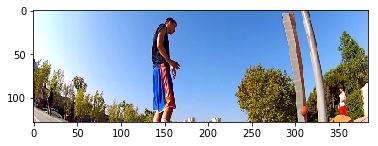

In [5]:
test_frame0=np.load('src/t0_frame.npy')
test_frame1=np.load('src/t1_frame.npy')

img_test = test_frame0[0,:,:,:]

print(img_test.shape)
plt.imshow(img_test)

## 2.bulid model

In [6]:
from keras.layers import Dense,Deconv2D,Conv2D,BatchNormalization,Activation,Concatenate,Reshape,Conv1D,Permute, Lambda
from keras.engine.topology import Layer

In [7]:
sess = tf.Session()

from keras import backend as K
K.set_session(sess)

### 2.1 place holdholer 
- a pair of input frame ** $I_t ,I_{t+1}$ ** (임의로 추출된 연속된 두 frame)

In [8]:
def model_input(img_h,img_w,img_c):
    I_t0 = tf.placeholder(tf.float32,(None, img_h, img_w, img_c), name='frame_t0')
    I_t1 = tf.placeholder(tf.float32,(None, img_h, img_w, img_c), name='frame_t1')
    
    return I_t0, I_t1

#### 2.1.1 place holder shape for debug

In [9]:
img_h,img_w,img_c = 128, 384, 3

I_t0, I_t1 = model_input(img_h,img_w,img_c)

assert I_t0.shape.as_list()==[None,128,384,3]
assert I_t1.shape.as_list()==[None,128,384,3]

###  2.2 basic structure of Conv, Deconv
Convolution layer와 Activation, Batch Normalization layer를 하나의 Block으로 관리한다.

In [10]:
def conv(h_0,filters,kernel_size,strides):
        kernel_initializer = keras.initializers.TruncatedNormal(mean=0.0,stddev=0.0001)
        h1 = Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same',kernel_initializer=kernel_initializer)(h_0)
        h1_bn = BatchNormalization()(h1,training=True)
        h1_o = Activation('relu')(h1_bn)
        return h1_o
    
def deconv(h_0,filters,kernel_size,strides):
        kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0,stddev=0.0001)
        h1 = Deconv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same',kernel_initializer=kernel_initializer)(h_0)
        h1_bn = BatchNormalization()(h1,training=True)
        h1_o = Activation('relu')(h1_bn)
        return h1_o

### 2.3 Basic neural network 
해당 함수는 전체 Motion Network와 Struct Network의 모양이 서로 같기때문에 호출을 용이하게 하기 위해서 생성했다.

In [11]:
def conv_deconv_net(frame):

    ###to deconv
    h10_o=conv(frame,filters=32,kernel_size=3,strides=1)
    h11_o=conv(h10_o,filters=64,kernel_size=3,strides=2)
    
    ###to deconv
    h20_o=conv(h11_o,filters=64,kernel_size=3,strides=1)
    h21_o=conv(h20_o,filters=128,kernel_size=3,strides=2)

    ###to deconv
    h30_o=conv(h21_o,filters=128,kernel_size=3,strides=1)
    h31_o=conv(h30_o,filters=256,kernel_size=3,strides=2)
    
    ###to deconv
    h40_o=conv(h31_o,filters=256,kernel_size=3,strides=1)
    h41_o=conv(h40_o,filters=512,kernel_size=3,strides=2)
    
    ###to deconv
    h50_o=conv(h41_o,filters=512,kernel_size=3,strides=1)
    h51_o=conv(h50_o,filters=1024,kernel_size=3,strides=2)
    
    #embeding layer
    embeding=conv(h51_o,filters=1024,kernel_size=3,strides=1)

    #deconv
    d5=deconv(embeding,filters=512,kernel_size=3,strides=2)
    d4_i=Concatenate(axis=-1)([d5,h50_o])
    
    d4=deconv(d4_i,filters=256,kernel_size=3,strides=2)
    d3_i=Concatenate(axis=-1)([d4,h40_o])
    
    d3=deconv(d3_i,filters=128,kernel_size=3,strides=2)
    d2_i=Concatenate(axis=-1)([d3,h30_o])

    d2=deconv(d2_i,filters=64,kernel_size=3,strides=2)
    d1_i=Concatenate(axis=-1)([d2,h20_o])

    out=deconv(d1_i,filters=32,kernel_size=3,strides=2)

    return out,embeding

## 3. Related to Depth Network

### 3.1 Depth Network
Depth Network는 Structure Network의 일부분으로 section 2에서 구현한 함수를 호출함으로써 구현한다. 해당 network의 출력은 논문에서 언급된 바와 같이 bias값을 주기 위해서, Keras의 Lambda function을 이용했으며, 또한 예측된 depth의 크기를 100으로 한정시켰다.

In [12]:
def dep_relu(x):
    x=tf.clip_by_value(x, 0, 50)
    return x

def depth_net(frame):
    top,_ = conv_deconv_net(frame)
    top = Conv2D(filters=1,kernel_size=1,strides=1,padding='same',kernel_initializer=keras.initializers.glorot_normal())(top)
    top = Lambda(lambda x: x+1)(top)   
    depth = Activation(dep_relu)(top)
    
    return depth

###  3.2 depth to point cloud
![](fig/depthtocloud.png)

where ** $d_t^i $** denotes the depth value of the $i$th pixel. We use
the camera intrinsics when available and revert to default
values of $(0.5, 0.5, 1.0)$ Therefore, the predicted depth will only be correct up to a scalar multiplier.[논문 인용]

In [13]:
class Cloud_transformer():
    def __init__(self, intrinsics=[0.5, 0.5, 1.0], **kwargs):
        self.output_dim = 3
        self.cam_intrinsics = intrinsics
        self.build()

    def build(self):
        self.cx_ = self.cam_intrinsics[0]
        self.cy_ = self.cam_intrinsics[1]
        self.cf_ = self.cam_intrinsics[2]
        
        self.cx=tf.constant(self.cam_intrinsics[0],dtype=tf.float32)
        self.cy=tf.constant(self.cam_intrinsics[1],dtype=tf.float32)
        self.cf=tf.constant(self.cam_intrinsics[2],dtype=tf.float32)
        
    def mesh_grid(self, width, height):
        '''
        output: [(xi/w-cx)/f,(yi/h-cy)/f,1] 형태의 grid 함수
        '''
        x_linspace=tf.linspace(-self.cx_, 1-self.cx_, width)
        y_linspace=tf.linspace(-self.cy_, 1-self.cy_, height)
        
        y_cord,x_cord=tf.meshgrid(y_linspace, x_linspace)
        
        x_cord=tf.reshape(x_cord,[-1])
        y_cord=tf.reshape(y_cord,[-1])
        
        f_=tf.ones_like(x_cord)
        
        x_=tf.div(x_cord, self.cf)
        y_=tf.div(y_cord, self.cf)
        
        grid=tf.concat([x_,y_,f_],0)
        return grid
        
    def transform(self,x):
        """
        [(xi/w-cx)/f,(yi/h-cy)/f,1]
        
        next just 
        
        d*[(xi/w-cx)/f,(yi/h-cy)/f,1]
         to get [Xi,Yi,Zi]
        
        """
        
        #get input shape
        batch_size = tf.shape(x)[0]
        width = tf.shape(x)[1]
        height = tf.shape(x)[2]
        channel = tf.shape(x)[3]
        
        # Change Data type: Maybe... 
        batch_size = tf.cast(batch_size, tf.int32)
        width = tf.cast(width,tf.int32)
        height = tf.cast(height,tf.int32)
        channel = tf.cast(channel,tf.int32)
        
        #grid
        grid = self.mesh_grid(width, height)
        grid = tf.expand_dims(grid, 0)
        grid = tf.reshape(grid, [-1])
                
        grid_stack = tf.tile(grid, tf.stack([batch_size]))
        grid_stack = tf.reshape(grid_stack,[batch_size,3,-1])
        
        depth = tf.reshape(x,[batch_size,1,-1])
        depth = tf.concat([depth]*self.output_dim,1)
        
        point_cloud = tf.multiply(depth,grid_stack)
        
        return point_cloud

    def __call__(self, x):
        point_cloud = self.transform(x)
        return point_cloud

### 3.3 Structure Network

In [14]:
def structure_net(input_frame, reuse = False):
    with tf.variable_scope('structure_net', reuse = reuse):
        depth_output = depth_net(input_frame)
        point_cloud_output = Cloud_transformer()(depth_output)
        return point_cloud_output, depth_output

##  3. Related to Motion Network

### 3.1 param_net
Get 3D rigid motions parameter

- p $[px,py,pz]$:rotation pivot points 
    * use a sigmoid activation to predict a weight avarage in a $20m \times 30m$ grid  
- t $[tx,ty,tz]$: linear movement translation 
- r $[sin(a),sin(b),sin(y)]$: Euler angle representation

![](fig/scenemotion_.jpg)

Objective Mask는 각 pixel에 대한 대표 3개의 Object에 속할 확률값을 의미할 수 있도록 마지막 activation을 softmax를 이용했다. 즉 1번 channel에 존재하는 Matrix는 1번 Object에 속할 확률에 대해 저장되어 있다.

In [15]:
def sin_relu(x):
    x=tf.clip_by_value(x, -1., 1.)
    return x

def param_net(frame_t0,frame_t1,k_obj=4,):
    init=keras.initializers.TruncatedNormal(mean=0.0,stddev=0.0001)
    frame_pair=tf.concat([frame_t0,frame_t1],-1)
    
    top,embed = conv_deconv_net(frame_pair)

    embed = Dense(512,kernel_initializer=init)(embed)
    embed = Dense(512,kernel_initializer=init)(embed)
    embed = Reshape([-1])(embed)

    # Camera Position
    cam_t_= Dense(3, kernel_initializer=init)(embed)
    cam_t = Activation('relu')(cam_t_)
    cam_r = Dense(3, kernel_initializer=init)(embed)
    cam_r = Activation(sin_relu)(cam_r)
    cam_p = Dense(600, kernel_initializer=init)(embed)
    cam_p = Activation('relu')(cam_p)

    # Objective Position    
    obj_t = Activation('relu')(Dense(3*k_obj,kernel_initializer=init)(embed))
    obj_t = tf.reshape(obj_t,(-1,k_obj,3))
    obj_p = Activation('relu')(Dense(600*k_obj,kernel_initializer=init)(embed))
    obj_p = tf.reshape(obj_p,(-1,k_obj,600))    
    obj_r = Activation(sin_relu)(Dense(3*k_obj,kernel_initializer=init)(embed))
    obj_r = tf.reshape(obj_r,(-1,k_obj,3))
    
    #Objective Mask
    mask = Conv2D(filters=k_obj,kernel_size=1,strides=1,padding='same',kernel_initializer=init)(top)
    obj_mask= Activation('sigmoid')(mask)
    
    return [cam_t,cam_p,cam_r],[obj_t,obj_p, obj_r, obj_mask]


### 3.2 get Optical flow and motion field

![](fig/Optical_Flow.png)

In [16]:
class Optical_transformer():

    def __init__(self,intrinsics=[0.5,0.5,1.0],img_shape=[384,128], **kwargs):
        
        self.cam_intrinsics = intrinsics
        self.img_w=self.np_tf(img_shape[0])
        self.img_h=self.np_tf(img_shape[1])
        self.img_w_=float(img_shape[0])
        self.img_h_=float(img_shape[1])
        
        
        self.cx_=self.cam_intrinsics[0]
        self.cy_=self.cam_intrinsics[1]
        self.cf_=self.cam_intrinsics[2]
        
        
        self.cx=self.np_tf(self.cam_intrinsics[0])
        self.cy=self.np_tf(self.cam_intrinsics[1])
        self.cf=self.np_tf(self.cam_intrinsics[2])
        

        so3_a=np.array([
            [0,-1,0,1,0,0,0,0,0],
            [1,0,0,0,1,0,0,0,0],
            [0,0,0,0,0,0,0,0,1]
        ])

        so3_b=np.array([
            [0,0,1,0,0,0,-1,0,0],
            [1,0,0,0,0,0,0,0,1],
            [0,0,0,0,1,0,0,0,0]
        ])

        so3_y=np.array([
            [0,0,0,0,0,-1,0,1,0],
            [0,0,0,0,1,0,0,0,1],
            [1,0,0,0,0,0,0,0,0]
        ])

        self.so3_a=self.np_tf(so3_a)
        self.so3_b=self.np_tf(so3_b)
        self.so3_y=self.np_tf(so3_y)
        
  
    def np_tf(self,array):
        return tf.constant(array,tf.float32)

    def build(self,cam_motion,obj_motion,x):
                
        self.cam_motion=cam_motion
        
        self.obj_motion=obj_motion
        self.mask_size=obj_motion[0].shape.as_list()[1]
        self.x_shape=x.shape.as_list()
        
    
#    tranformation     
    def so3_mat(self,sin):
        #input :sin a,sin b,sin y 
        #return : SO3
        sin = tf.expand_dims(sin,-1)
        cos = tf.sqrt(tf.ones_like(sin)-tf.square(sin))
        t = tf.concat([sin, cos, tf.ones_like(sin)],-1)

        t_a=tf.slice(t,[0,0,0],[-1,1,-1])
        t_b=tf.slice(t,[0,1,0],[-1,1,-1])
        t_y=tf.slice(t,[0,2,0],[-1,1,-1])
        
        t_a=tf.reshape(t_a,(-1,3))
        t_b=tf.reshape(t_b,(-1,3))
        t_y=tf.reshape(t_y,(-1,3))
        
        soa=tf.matmul(t_a,self.so3_a)
        soa=tf.reshape(soa,(-1,3,3))
        
        sob=tf.matmul(t_b,self.so3_b)
        sob=tf.reshape(sob,(-1,3,3))
        soy=tf.matmul(t_y,self.so3_y)
        soy=tf.reshape(soy,(-1,3,3))
   
        so3=tf.matmul(soa,  tf.matmul(sob,soy))
        return so3
    
    def pior_pont(self,p):
        batch_size=p.shape.as_list()[0]
        p_ret=tf.reshape(p,(-1,30,20))
        p_y=tf.reduce_sum(p_ret,1)
        p_x=tf.reduce_sum(p_ret,2)
        x_loc=tf.linspace(-30.0,30.0,30)
        y_loc=tf.linspace(-20.,20.,20)
        P_x_loc=tf.reduce_mean(tf.multiply(p_x,x_loc))
        P_x_loc=tf.reshape(P_x_loc,(-1,1))
        P_y_loc=tf.reduce_mean(tf.multiply(p_y,y_loc))
        P_y_loc=tf.reshape(P_y_loc,(-1,1))
        
        ground=tf.ones_like(P_y_loc)
        P=tf.concat([P_x_loc,P_y_loc,ground],1)
        
        return P
    
    def rigid_motion(self,x,R,p,t):
        p=tf.expand_dims(p,-1)      
        t=tf.expand_dims(t,-1)
        motion=tf.add(tf.matmul(R,tf.subtract(x,p)),t)

        return motion
          
    
    def cam_motion_transform(self,x):
        t,p,sin=self.cam_motion
        p=self.pior_pont(p)
        R=self.so3_mat(sin)
        X=self.rigid_motion(x,R,p,t) 
        return X
        
  
    def obj_motion_transform(self,x_input):
        t,p,sin,mask=self.obj_motion
        p = self.pior_pont(p)
        sin = tf.reshape(sin,(-1,3))
        p = tf.reshape(p,(-1,3))
        t = tf.reshape(t,(-1,3))
        x_in = tf.expand_dims(x_input,1)
        x_exp = tf.concat([x_in]*self.mask_size,1)
        x_ = tf.reshape(x_exp,(-1,3,384*128))
        R=self.so3_mat(sin)
        x=self.rigid_motion(x_,R,p,t)
        
        x=tf.reshape(x,(-1,self.mask_size,3,384*128))
        x,motion_map=self.mask_motion(x,mask,x_exp)
        X=tf.add(x_input,x)
        
        
        return X,motion_map
    
    def mask_motion(self,x,mask,x_exp):
        mask = tf.reshape(mask,(-1,self.mask_size,1,384*128))
        x = tf.subtract(x,x_exp)

        motion_map = tf.multiply(x,mask)
        x = tf.reduce_sum(motion_map,1)
        
        return x, motion_map
        
        
    def tranform_2d(self,x):
        x_3d=tf.slice(x,(0,0,0),(-1,1,49152))
        y_3d=tf.slice(x,(0,1,0),(-1,1,49152))
        z_3d=tf.slice(x,(0,2,0),(-1,1,49152))
        x_z=tf.div(x_3d,z_3d)
        y_z=tf.div(y_3d,z_3d)
        
        x_2d=tf.add(tf.multiply(self.cf,x_z),self.cx)
        y_2d=tf.add(tf.multiply(self.cf,y_z),self.cy)
        pos_2d_new=tf.concat([x_2d,y_2d],1)
        return pos_2d_new

    def get_flow(self,pos_2d_new):
        x_linspace = tf.linspace(0.,1.,int(self.img_w_))
        y_linspace = tf.linspace(0.,1.,int(self.img_h_))
        
        y_linspace,x_linspace = tf.meshgrid(y_linspace,x_linspace)
        x_linspace = tf.reshape(x_linspace, [1,-1])
        y_linspace = tf.reshape(y_linspace, [1,-1])
        
        pos_ori=tf.concat([x_linspace,y_linspace],0)
        flow = tf.subtract(pos_2d_new, pos_ori)
        
        return flow

  
    def __call__(self,x,cam_motion,obj_motion,):
        self.build( cam_motion,obj_motion,x)

        point_cloud, motion_map = self.obj_motion_transform(x)        
        point_cloud = self.cam_motion_transform(point_cloud)
        pix_pos=self.tranform_2d(point_cloud)
        
        flow = self.get_flow(pix_pos)
        motion_map=tf.reshape(motion_map,(-1,img_h,img_w,1))
        return pix_pos, flow, point_cloud, motion_map

In [17]:
def motion_net(input_frame_0,input_frame_1,point_cloud_0,reuse=False):
    with tf.variable_scope('motion_net',reuse=reuse):
        cam_motion,obj_motion=param_net(input_frame_0,input_frame_1,k_obj=4,)
        pix_pos,flow,point_cloud,motion_map=Optical_transformer()(point_cloud_0,cam_motion,obj_motion,)
        return pix_pos,flow,point_cloud,motion_map

##  4. loss function

### 4.1 Self-Supervision
해당 loss function은 differtial warping을 이용한 Loss function으로 Unsupervised Learning을 가능하게 하는 Loss이다.

![](fig/self.png)

In [18]:
class get_frame_loss():
    def __init__(self):
        self.output_size = [128,384]
        
    def __call__(self, frame0, frame1,pos_2d_new,reuse=False):
        with tf.variable_scope('frame_loss',reuse=reuse):
            batch_size = tf.shape(frame1)[0]
            height = 128
            width = 384
            num_channels = 3
            output_height=128
            output_width=384

            x_s = tf.slice(pos_2d_new, [0, 0, 0], [-1, 1, -1])
            y_s = tf.slice(pos_2d_new, [0, 1, 0], [-1, 1, -1])
            x_s_flatten = tf.reshape(x_s, [-1])
            y_s_flatten = tf.reshape(y_s, [-1])

            transformed_image \
            = self._interpolate(frame1, x_s_flatten, y_s_flatten, self.output_size)

            transformed_image \
            = tf.reshape(transformed_image, \
                         shape=(-1, output_height, output_width, num_channels))

            loss=self.compute_loss(frame0, transformed_image)
 
            return loss
    
    
    def compute_loss(self,frame0,transformed_image):
        loss=tf.reduce_mean(tf.abs(tf.subtract( frame0,transformed_image)))
        return loss
        
    def _interpolate(self, image, x, y, output_size):
        batch_size = tf.shape(image)[0]
        height = 128
        width = 384
        num_channels = tf.shape(image)[3]

        x = tf.cast(x , dtype='float32')
        y = tf.cast(y , dtype='float32')

        height_float = tf.cast(height, dtype='float32')
        width_float = tf.cast(width, dtype='float32')

        output_height = output_size[0]
        output_width  = output_size[1]

        x =x*(width_float)
        y =y*(height_float)

        x0 = tf.cast(tf.floor(x), 'int32')
        x1 = x0 + 1
        y0 = tf.cast(tf.floor(y), 'int32')
        y1 = y0 + 1

        max_y = tf.cast(height - 1, dtype='int32')
        max_x = tf.cast(width - 1,  dtype='int32')
        
        zero = tf.zeros([], dtype='int32')

        x0 = tf.clip_by_value(x0, zero, max_x)
        x1 = tf.clip_by_value(x1, zero, max_x)
        y0 = tf.clip_by_value(y0, zero, max_y)
        y1 = tf.clip_by_value(y1, zero, max_y)

        flat_image_dimensions = width*height
        pixels_batch = tf.range(batch_size)*flat_image_dimensions
        flat_output_dimensions = output_height*output_width
        base = self._repeat(pixels_batch, flat_output_dimensions)
        base_y0 = base + y0*width
        base_y1 = base + y1*width
        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = tf.reshape(image, shape=(-1, num_channels))
        flat_image = tf.cast(flat_image, dtype='float32')
        pixel_values_a = tf.gather(flat_image, indices_a)
        pixel_values_b = tf.gather(flat_image, indices_b)
        pixel_values_c = tf.gather(flat_image, indices_c)
        pixel_values_d = tf.gather(flat_image, indices_d)
        
        x0 = tf.cast(x0, 'float32'); x1 = tf.cast(x1, 'float32');
        y0 = tf.cast(y0, 'float32'); y1 = tf.cast(y1, 'float32');

        area_a = tf.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = tf.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = tf.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = tf.expand_dims(((x - x0) * (y - y0)), 1)
        output = tf.add_n([area_a*pixel_values_a,
                           area_b*pixel_values_b,
                           area_c*pixel_values_c,
                           area_d*pixel_values_d])
        return output
        
    def _repeat(self, x, num_repeats):
        ones = tf.ones((1, num_repeats), dtype='int32')
        x = tf.reshape(x, shape=(-1,1))
        x = tf.matmul(x, ones)
        return tf.reshape(x, [-1])
    
    

### 4.2 Spatial smoothness priors
고정된 convolution layer를 이용해서 TV regularization을 구한다.
또한, 학습 초반에서 살펴볼 수 있듯이 격자무늬 패턴을 완화하기 위한 Loss이다. 

In [19]:
class get_smooth_loss():
    def __init__(self,kernel=[[1,2,1],[0,0,0],[-1,-2,-1]],order=1):
        self.kernel=np.array(kernel)
        self.order=order
        
        
    def build(self,field_c):
        v_kernel=self.kernel
        h_kernel=self.kernel.T
        h_init=keras.initializers.Constant(value=h_kernel)
        v_init=keras.initializers.Constant(value=v_kernel)
        
        self.conv_h=Conv2D(filters=field_c,kernel_size=3,strides=1,kernel_initializer=h_init,padding='same')
        self.conv_h.trainable=False
        self.conv_v=Conv2D(filters=field_c,kernel_size=3,strides=1,kernel_initializer=v_init,padding='same')
        self.conv_v.trainable=False
        
    def compute_gradient(self,field):
        loss_v = self.conv_v(field)
        loss_h = self.conv_h(field)
        
        gradient_loss = loss_h + loss_v
        
        return gradient_loss
        
    def compute_loss(self,field):
        f1_gradient_loss=self.compute_gradient(field)
        
        if self.order==1:
            loss=tf.reduce_mean(tf.abs(f1_gradient_loss),-1)
            loss=tf.reduce_mean(loss)
            
        if self.order==2:
            f2_gradient_loss=self.compute_gradient(f1_gradient_loss)
            
            loss=tf.reduce_mean(tf.abs(f2_gradient_loss),-1)
            loss=tf.reduce_mean(loss)
          
        return loss

    def __call__(self,field,loss_type=None,reuse=False):
        with tf.variable_scope(loss_type,reuse=reuse):
            if loss_type=='flow':
                field=Permute((2,1))(field)
                field=tf.reshape(field,(-1,128,384,2))
                field_c=field.shape.as_list()[1]

            field_c = field.shape.as_list()[-1]

            self.build(field_c)
            loss=self.compute_loss(field)
            return loss

### 4.3 Forward-backward consistency constraints.
해당 네트워크는 2개의 쌍을 이루는 네트워크 구조를 가지고, 이들간에는 Weight sharing이 일어나고 있다. 따라서 다른 입력이 주어진 경우에 나오는 결과여도 동일한 결과가 나올 수 있도록 학습시킨다.

In [20]:
class get_fb_depth_loss():
    def __init__(self):
        self.output_size=[128,384]
    def __call__(self,depth0, depth1, pos_2d_new, motion, reuse=False):
        with tf.variable_scope('fb_depth_loss',reuse=reuse):
            batch_size = tf.shape(depth0)[0]
            height = tf.shape(depth0)[1]
            width = tf.shape(depth0)[2]
            num_channels = tf.shape(depth0)[3]
            output_height=self.output_size[0]
            output_width=self.output_size[1]

            x_s = tf.slice(pos_2d_new, [0, 0, 0], [-1, 1, -1], name='err')
            y_s = tf.slice(pos_2d_new, [0, 1, 0], [-1, 1, -1])
            x_s_flatten = tf.reshape(x_s, [-1])
            y_s_flatten = tf.reshape(y_s, [-1])

            transformed_depth1 = self._interpolate(depth1,
                                                    x_s_flatten,
                                                    y_s_flatten,
                                                    self.output_size)

            transformed_depth1 = tf.reshape(transformed_depth1, shape=(-1,
                                                                    output_height,
                                                                    output_width,
                                                                     num_channels))

            motion_z=tf.slice(motion,[0,2,0],[-1,1,-1])
            motion_z=tf.reshape(motion_z,(-1,output_height,output_width,1))
            transformed_depth0=tf.add(depth0,motion_z)
            loss=self.compute_loss( transformed_depth0,transformed_depth1 )
        return loss
    
    
    def compute_loss(self, transformed_depth0, transformed_depth1):
        loss=tf.reduce_mean(tf.abs(tf.subtract( transformed_depth0,transformed_depth1)))
        return loss        
        
    def _interpolate(self, image, x, y, output_size):
        batch_size = tf.shape(image)[0]
        height = tf.shape(image)[1]
        width = tf.shape(image)[2]
        num_channels = tf.shape(image)[3]

        x = tf.cast(x , dtype='float32')
        y = tf.cast(y , dtype='float32')

        height_float = tf.cast(height, dtype='float32')
        width_float = tf.cast(width, dtype='float32')

        output_height = output_size[0]
        output_width  = output_size[1]

        x =x*(width_float)
        y = y*(height_float)

        x0 = tf.cast(tf.floor(x), 'int32')
        x1 = x0 + 1
        y0 = tf.cast(tf.floor(y), 'int32')
        y1 = y0 + 1

        max_y = tf.cast(height - 1, dtype='int32')
        max_x = tf.cast(width - 1,  dtype='int32')
        zero = tf.zeros([], dtype='int32')

        x0 = tf.clip_by_value(x0, zero, max_x)
        x1 = tf.clip_by_value(x1, zero, max_x)
        y0 = tf.clip_by_value(y0, zero, max_y)
        y1 = tf.clip_by_value(y1, zero, max_y)

        flat_image_dimensions = width*height
        pixels_batch = tf.range(batch_size)*flat_image_dimensions
        flat_output_dimensions = output_height*output_width
        base = self._repeat(pixels_batch, flat_output_dimensions)
        base_y0 = base + y0*width
        base_y1 = base + y1*width
        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = tf.reshape(image, shape=(-1, num_channels))
        flat_image = tf.cast(flat_image, dtype='float32')
        pixel_values_a = tf.gather(flat_image, indices_a)
        pixel_values_b = tf.gather(flat_image, indices_b)
        pixel_values_c = tf.gather(flat_image, indices_c)
        pixel_values_d = tf.gather(flat_image, indices_d)

        x0 = tf.cast(x0, 'float32')
        x1 = tf.cast(x1, 'float32')
        y0 = tf.cast(y0, 'float32')
        y1 = tf.cast(y1, 'float32')

        area_a = tf.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = tf.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = tf.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = tf.expand_dims(((x - x0) * (y - y0)), 1)
        output = tf.add_n([area_a*pixel_values_a,
                           area_b*pixel_values_b,
                           area_c*pixel_values_c,
                           area_d*pixel_values_d])
        return output
        
    def _repeat(self, x, num_repeats):
        ones = tf.ones((1, num_repeats), dtype='int32')
        x = tf.reshape(x, shape=(-1,1))
        x = tf.matmul(x, ones)
        return tf.reshape(x, [-1])

## 5. Model implementation

In [21]:
f_point_cloud_1,f_depth_output=structure_net(I_t0)
b_point_cloud_1,b_depth_output=structure_net(I_t1,reuse=True)

In [22]:
f_pix_pos,f_flow,f_point_cloud_2,f_motion_map=motion_net(I_t0,I_t1,f_point_cloud_1)
b_pix_pos,b_flow,b_point_cloud_2,b_motion_map=motion_net(I_t1,I_t0,b_point_cloud_1,reuse=True)

In [23]:
f_frame_loss=get_frame_loss()(I_t0,I_t1,f_pix_pos)
b_frame_loss=get_frame_loss()(I_t1,I_t0,b_pix_pos,reuse=True)

In [24]:
f_flow_sm_loss = get_smooth_loss(order=1)(f_flow,'flow')
b_flow_sm_loss = get_smooth_loss(order=1)(b_flow,'flow',reuse=True)

f_depth_sm_loss = get_smooth_loss(order=2)(f_depth_output,'depth')
b_depth_sm_loss = get_smooth_loss(order=2)(b_depth_output,'depth',reuse=True)

f_motion_sm_loss = get_smooth_loss(order=1)(f_motion_map,'motion')
b_motion_sm_loss = get_smooth_loss(order=1)(b_motion_map,'motion',reuse=True)

In [25]:
f_depth_loss = get_fb_depth_loss()(f_depth_output,b_depth_output,f_pix_pos,f_point_cloud_1)
b_depth_loss = get_fb_depth_loss()(b_depth_output,f_depth_output,b_pix_pos,b_point_cloud_1,reuse=True)

In [26]:
total_loss = f_depth_loss +f_depth_sm_loss+f_motion_sm_loss+f_flow_sm_loss+f_frame_loss+\
   b_depth_loss+b_depth_sm_loss+b_motion_sm_loss+b_flow_sm_loss+b_frame_loss
    
train_op=tf.train.AdamOptimizer(learning_rate=0.0003,beta1=0.9).minimize(total_loss)

/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


###  5.1 Train 관련 변수
학습과정을 Tensorboard로 관찰하기 위함

In [27]:
tf.summary.scalar('Total_loss', total_loss)

tf.summary.scalar('f_depth_loss', f_depth_loss)
tf.summary.scalar('f_depth_sm_loss', f_depth_sm_loss)
tf.summary.scalar('f_motion_sm_loss', f_motion_sm_loss)
tf.summary.scalar('f_flow_sm_loss', f_flow_sm_loss)
tf.summary.scalar('f_frame_loss', f_frame_loss)

tf.summary.image('b_depth_output',b_depth_output/100,1)
tf.summary.image('f_depth_output',f_depth_output/100,1)

tf.summary.image('b_depth_output_scale',b_depth_output*10,1)
tf.summary.image('f_depth_output_scale',f_depth_output*10,1)

meger_summary=tf.summary.merge_all()

### 5.2 Train을 위한 준비 및 관찰 tool setting

In [28]:
!rm -r ./tmp/ #sfmnet 학습 관찰용 folder

In [29]:
!rm -r checkpoint
!mkdir checkpoint #sfmnet 모델 저장 folder

In [30]:
write=tf.summary.FileWriter('./tmp/')
write.add_graph(sess.graph)

### 5.3 train

In [31]:
sess.run(tf.global_variables_initializer())
saver=tf.train.Saver()

for step in range(10000):
    ckpt = tf.train.get_checkpoint_state('./checkpoint/')
    if (step==0) and ckpt and ckpt.model_checkpoint_path:
        print('load model')
        saver.restore(sess, ckpt.model_checkpoint_path)

    feed_dict={I_t0:test_frame0,I_t1: test_frame1}
    
    _=sess.run([train_op],feed_dict=feed_dict)
     

    if step%20==0:
        train_loss=sess.run(total_loss,feed_dict=feed_dict)
        print(train_loss)
        
    if step%100==0:
        print("merger")
        s=sess.run(meger_summary,feed_dict=feed_dict)
        write.add_summary(s,step)
        write.flush()
        saver.save(sess, './checkpoint/'+'my-model', global_step=step)
        
write.close()
sess.close()

ResourceExhaustedError: OOM when allocating tensor of shape [512] and type float
	 [[Node: structure_net_1/conv2d_transpose_6/bias/Adam/Initializer/zeros = Const[_class=["loc:@structure_net_1/conv2d_transpose_6/bias"], dtype=DT_FLOAT, value=Tensor<type: float shape: [512] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'structure_net_1/conv2d_transpose_6/bias/Adam/Initializer/zeros', defined at:
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-567d6aef2f52>", line 3, in <module>
    train_op=tf.train.AdamOptimizer(learning_rate=0.0003,beta1=0.9).minimize(total_loss)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 325, in minimize
    name=name)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 446, in apply_gradients
    self._create_slots([_get_variable_for(v) for v in var_list])
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/training/adam.py", line 132, in _create_slots
    self._zeros_slot(v, "m", self._name)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 766, in _zeros_slot
    named_slots[_var_key(var)] = slot_creator.create_zeros_slot(var, op_name)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/training/slot_creator.py", line 174, in create_zeros_slot
    colocate_with_primary=colocate_with_primary)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/training/slot_creator.py", line 146, in create_slot_with_initializer
    dtype)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/training/slot_creator.py", line 66, in _create_slot_var
    validate_shape=validate_shape)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 1065, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 962, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 367, in get_variable
    validate_shape=validate_shape, use_resource=use_resource)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 352, in _true_getter
    use_resource=use_resource)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 725, in _get_single_variable
    validate_shape=validate_shape)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 199, in __init__
    expected_shape=expected_shape)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 277, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 701, in <lambda>
    shape.as_list(), dtype=dtype, partition_info=partition_info)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py", line 93, in __call__
    return array_ops.zeros(shape, dtype)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1401, in zeros
    output = constant(zero, shape=shape, dtype=dtype, name=name)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/framework/constant_op.py", line 106, in constant
    attrs={"value": tensor_value, "dtype": dtype_value}, name=name).outputs[0]
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/siyeong/Playground/anaconda2/envs/keras-2/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [512] and type float
	 [[Node: structure_net_1/conv2d_transpose_6/bias/Adam/Initializer/zeros = Const[_class=["loc:@structure_net_1/conv2d_transpose_6/bias"], dtype=DT_FLOAT, value=Tensor<type: float shape: [512] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


### 5.4 Inference
최신의 model로 부터 주어진 input이 제대로 출력하는지 확인하는 과정

In [ ]:
sess.run(tf.global_variables_initializer())
saver=tf.train.Saver()

ckpt = tf.train.get_checkpoint_state('./checkpoint/')
saver.restore(sess, ckpt.model_checkpoint_path)

feed_dict={I_t0:test_frame0,I_t1: test_frame1}
    
a = sess.run(f_depth_output, feed_dict=feed_dict)

print(a)

### 5.5 Optical flow의 확인 코드

In [ ]:
x_flow = a[:,0,:]
x_flow = x_flow.reshape(128,384)

y_flow = a[:,1,:]
y_flow = y_flow.reshape(128,384)

In [ ]:
X, Y = np.mgrid[0:384, 0:128]
plt.quiver(X, Y, x_flow, y_flow)
plt.show()